# Nathaniel Hobbs: Data Mining Project (classifying flowers)

## Intro

This project will use a data set from kaggle of flowers and train multiple models for the purpose of classification.

I am running this notebook off Anaconda 3 v1.50. Parts of this notbook requires packages bcolz and theano (alternative to tensorflow), which aren't installed by default on the aforementioned version of Anaconda.  They can be installed via Anaconda Navagator.

The flower dataset can be found at: https://www.kaggle.com/alxmamaev/flowers-recognition

We will be using the some pretrained neural nets including:
- VGG16, the 16-layer network used by the VGG team in the ILSVRC-2014 competition. Details on the architechture can be found on arXiv

    ``  Very Deep Convolutional Networks for Large-Scale Image Recognition
    K. Simonyan, A. Zisserman
    arXiv:1409.1556 ``
    
- Resnet 50, a residual network with 152 layers developed by Microsoft and used in the ILSVRC 2015, winning first place

    `` Deep Residual Learning for IMage Recognition
    K. He, X. Zhang, S Ren, J Sun
    arXiv:1512.0335v1``


The flower dataset is comprised 4242 images of flowers based on the data flicr, google images, yandex images:
- daisy : 764
- dandelion: 1055
- rose: 784
- sunflower: 734
- tulip: 984

Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

The zip files should be downloaded and placed in the directory of this Jupyter notebook file so that the commands will work to unzip them and set everything up correctly.

## Overview of Notebook


0. Set up environment, unzip kaggle data
1. Split data into training, test, and validation sets
2. Neurual Nets
    0. Download vgg16 and resnet50 architechtures from Keras (with weights from imagenet)
    1. "Finetune" models by modifying last layer and learning weights
    2. Test the models agaisnt test set
    3. Show overview of results

## Set up Environment

In [4]:
# Import all the packages we'll need
import os,sys    # for file and directory manipulation
import zipfile   # for unzipping file from kaggle
import requests  # for downloading from the internet
import errno     # if we get errors :(
import shutil    # for copying files
import numpy as np # for dealing with matrices of things
import matplotlib.pyplot as plt # for plotting

In [5]:
# Set up some variables we'll use throughout
HOME_DIR = os.getcwd()
print(HOME_DIR)
DATA_DIR = HOME_DIR+'/data'

C:\Users\owner\Documents\workspace\Jupyter Notebooks\flower_recognition


## Unzip kaggle

#### (can skip this part if already done once)

In [53]:
# unzip kaggle data file
if os.path.isfile(HOME_DIR+'/flowers-recognition.zip') == False:
    print("Data Set zip file not found, double check you have training data and place in notebook directory")
#elif os.path.isfile(HOME_DIR+'/keras-pretrained-models.zip') == False:
#   print("Keras pretrained models not found, double check you have them and place in notebook directory")
else:
    # flowers-recognition.zip just contains another zip called flowers.zip
    zipfile.ZipFile("flowers-recognition.zip").extractall(HOME_DIR+'/data')
    # unzip flowers.zip and put contentes in /data directory 
    zipfile.ZipFile(HOME_DIR+"/data/flowers.zip").extractall(HOME_DIR+'/data')
    # unzip keras pretrained models and put in /models/keras directory
 #   zipfile.ZipFile(HOME_DIR+"/keras-pretrained-models.zip").extractall(HOME_DIR+'/models/keras')
    # remove flowers.zip because we don't need it any more
    os.remove(HOME_DIR+'/data/flowers.zip')

zip files found!
done unzipping


# Split data into training, test, and validation sets

### Move kaggle data into appropriate directories and rename files according to their label

Move files into training, test, and validation folders (70% for training, 20% for test, 10% for validation)
training and test data 

The classes are broken up into different folders so we can associate images with label according to the directory structure (e.g. label [0,0,1,0,0] will correspond to "rose")

#####  Resulting directory structure


```
models/
utils/
data/
    flowers/                   *original data
        ...                       
    train/                     *training set with 70% of original data
        daisy/
        dandelion/
        rose/
        sunflower/
        tulip/
    test/                      *test set with 20% of data and folder for unknown class
       unknown/
    validate/                  *validation set with 10% of data
        daisy/
        dandelion/
        rose/
        sunflower/
        tulip/
    results/       
```

In [69]:
label_set = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
directories = ['train', 'test', 'validate', 'results']

# create directories if they don't exist and delete them if they do (so can run this again to get fresh batches of data)
for directory in directories:
    if os.path.isdir(HOME_DIR+'/data/'+directory):
        shutil.rmtree(HOME_DIR+'/data/'+directory)
    else:
        if directory == 'results':
            os.makedirs(HOME_DIR+'/data/'+directory)
        elif directory == 'test':
            os.makedirs(HOME_DIR+'/data/'+directory+'/unknown')
        else:
            for label in label_set:
                os.makedirs(HOME_DIR+'/data/'+directory+'/'+label)
        

# rename files, and copy into directories
counter = 10
for label in label_set:
    for filename in os.listdir(HOME_DIR+'/data/flowers/'+label):
        counter -= 1
        if counter > 3:
            shutil.copyfile(HOME_DIR+'/data/flowers/'+label+'/'+filename, HOME_DIR+'/data/train/'+label+'/'+filename)
        elif counter > 1:
            shutil.copyfile(HOME_DIR+'/data/flowers/'+label+'/'+filename, HOME_DIR+'/data/test/unknown/'+label+'.'+filename)
        else:
            shutil.copyfile(HOME_DIR+'/data/flowers/'+label+'/'+filename, HOME_DIR+'/data/validate/'+label+'/'+filename)
            counter += 10

## Create Batches of data for training set and validation set

A batch is a collection of images and labels.  We will have the neural nets colect data by the batch (images are associated with label according to the directory structure).

ImageDataGenerator is a python generator, it would yield a batch of data with the shape same with your model inputs (e.g. (batch_size,width,height,channels)) each time. Also, ImageDataGenerator works with model.fit_generator() and model.predict_generator().

The benefit of this is when with a big data set, we don't need to put the entire data set into memory. Instead we can use the generator to generate one batch data each time. 

If you want to get the numeric data, you can use the next() function of the generator, i.e. next(generator)

In [6]:
# set paths
test_path = HOME_DIR + '/data/test/'
results_path = HOME_DIR + '/data/results/'
train_path = HOME_DIR + '/data/train/'
valid_path = HOME_DIR + '/data/validate/'

In [7]:
# we define a method "get_batches" that is really a wrapper for ImageDataGenerator.flow_from_directory.
# the wrapper is so that we can control default values if they aren't passed in.

# outputs a DirectoryIterator yielding tuples of (x, y) where x is a numpy array containing a batch of 
# images with shape (batch_size, *target_size, channels) and y is a numpy array of corresponding labels.
from keras.preprocessing import image
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, batch_size=4, class_mode='categorical',
                target_size=(224,224)):
    return gen.flow_from_directory(dirname, target_size=target_size,
            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

C:\Users\owner\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
# set constants: 
# batch size usually recommended to be no larger than 64 (make smaller if running out of memory)
batch_size = 16

In [10]:
# get training batches and validation set batches
training_batches = get_batches(train_path, batch_size=batch_size)
validation_batches = get_batches(valid_path, batch_size=batch_size*2)

Found 3027 images belonging to 5 classes.
Found 432 images belonging to 5 classes.


### See what a batch looks like

In [11]:
# plots will display images and labels 
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

###### first batch

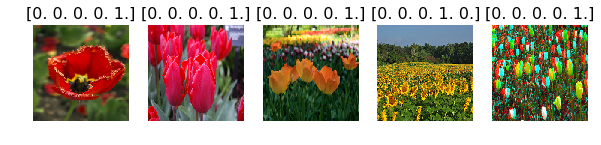

In [39]:
imgs,labels = next(training_batches)
plots(imgs[:5],titles=labels[:5])

##### second batch

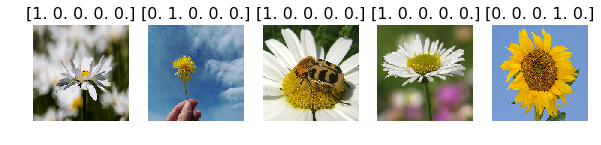

In [130]:
imgs,labels = next(training_batches)
plots(imgs[:5],titles=labels[:5])

# Classification via (pre-trained) Neural Nets

#### vgg16, resnet50, and mobilenet are an existing image classifiers trained to classify images into one of 1000 different categories found on imagenet.

In [12]:
# import things we need
import keras
from keras.applications.imagenet_utils import decode_predictions

### Load the different models initialized with imagenet weights for them (i.e. they're pretrained)

In [150]:
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
 
#Load the VGG model
vgg_model = vgg16.VGG16(weights='imagenet')
 
#Load the ResNet50 model
resnet_model = resnet50.ResNet50(weights='imagenet')

### Define helper methods

In [14]:
# Get the top predictions from neural net model (their output is all the same type, so can re-use this)
"""
Args:
    imgs (ndarray) : An array of N images (size N x width x height x channels)
    model          : The model we wish to use for prediction (defualt vgg16)
Returns:
     top_pred_confidences (np.array) : value of the probability of the predicted class with most confidence
     top_preds (list)                : class label of the predictions with the max confidence.
"""
def get_top_predictions(imgs, model=vgg16):
    # get the predicted probabilities for each class for each image
    all_predictions = model.predict(imgs)
    #print(all_predictions)
    
    # convert the probabilities to class labels for each image
    # will get top 5 predictions (the default) for each image
    all_top_labels = decode_predictions(all_predictions)
    #print(all_top_labels)
    
    top_preds = []
    top_pred_confidences = []
    # a single image has labels that are tuples of the form (class_name, class_description, score)
    for single_top_labels in all_top_labels:
        top_preds.append(single_top_labels[0][1])
        top_pred_confidences.append(single_top_labels[0][2])
    
 
    return top_preds, top_pred_confidences

#### Without any adjustments, let's see how the classifiers would classify some images from a batch

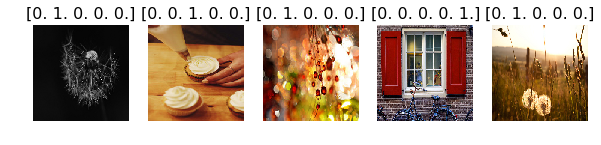

In [113]:
# display the first 5 images in a new batch
imgs,labels = next(training_batches)
plots(imgs[:5],titles=labels[:5])

In [114]:
vgg_preds, vgg_pred_confidences = get_top_predictions(imgs[:5],vgg_model)
print(vgg_preds)
print(vgg_pred_confidences)

['spider_web', 'candle', 'shower_curtain', 'pay-phone', 'swing']
[0.45274872, 0.19141275, 0.92828214, 0.20544796, 0.61824113]


In [115]:
resnet_preds, resnet_pred_confidences = get_top_predictions(imgs[:5], resnet_model)
print(resnet_preds)
print(resnet_pred_confidences)

['spider_web', 'joystick', 'loudspeaker', 'shopping_cart', 'shower_curtain']
[0.18898024, 0.2098834, 0.32057208, 0.2947891, 0.17200187]


## Finetune the neural nets

The neural nets we are using are using weights adjusted for the imagenet competition, i.e. made to categorize images into on of 1,000 different categories.  We want to "finetune" this model to just care about 5 different classes of flowers.

When finetuning we will provide the models with both a training set to learn from and a validation set to test against.  The resuling models will have the parameters tuned according to this data.

The basic idea is to remove the last layer of the original network (with 1,000) outputs, and replace it with a dense (fully connected) layer of with one neuron for each of the classes we care about (in our case 5 neurons: one for each kind of flower).

We will also lock the weights of all the layers except for the new layer we add, so we only learn weights for the last layer when training.

In [126]:
# check model summary before finetuning
vgg_model.summary()

###### Define helper functions

In [122]:
from keras.models import Model
from keras.layers import Dense,Flatten
from keras import backend as K
from keras.optimizers import SGD, Adam

"""
Args:
    model     : A model from keras.applications
    batches   : A keras.preprocessing.image.ImageDataGenerator object
    optimizer : which optimizer to use (default Adam, see https://keras.io/optimizers for choices)
    lr        : learning rate (default 0.001)
Returns:
    finetuned_model : A modified keras.preprocessing.image.ImageDataGenerator object where the last layer is replaced with 
                      a dense layer based on the classes in batches
"""
def finetune(model, batches, optimizer=Adam, lr=0.001):
    num_neurons = len(batches.class_indices)
    # batches.class_indices is a dict with the class name as the key and an index as the value
    # e.g. {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
    
    # print(model.summary())
    
    # remove last layer
    model.layers.pop()
    
    # lock the weights of the existing layers
    for layer in model.layers: 
        layer.trainable=False
        
    # add new dense layer
    new_layer = Dense(num_neurons, activation='softmax', name='finetuned_predictions')
    inp = model.input
    out = new_layer(model.layers[-1].output)
    finetuned_model = Model(inp, out)
    #finetuned_model.summary()
    
    # complile new model (see Keras documentation: https://keras.io/models/model)
    finetuned_model.compile(optimizer=optimizer(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    
    # get a list of all the class labels
    classes = list(iter(batches.class_indices)) 
    
    # sort the class labels by index according to batches.class_indices and update model.classes
    for single_class in batches.class_indices:
        classes[batches.class_indices[single_class]] = single_class
    finetuned_model.classes = classes
    
    return finetuned_model

# Fit the model on data yielded batch-by-batch by a Python generator.
"""
Args:
    model               : A model from keras.applications
    training_batches    : A keras.preprocessing.image.ImageDataGenerator object corresponding to training data
    validation_batches  : A keras.preprocessing.image.ImageDataGenerator object corresponding to validation data
    num_epoch            : How many epochs (iterations over the training set) to train 
Returns:
    model : A modified model where the last layer has weights that have fit batch data
"""
def fit(model, training_batches, validation_batches, num_epoch=1):
        model.fit_generator(training_batches, 
                            steps_per_epoch=training_batches.samples//training_batches.batch_size, 
                            #samples_per_epoch=training_batches.samples, 
                            epochs=num_epoch, 
                            validation_data=validation_batches, 
                            validation_steps=validation_batches.samples//validation_batches.batch_size) 
        return model

In [120]:
# check model summary before finetuning
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [127]:
# finetune() modifies model s.t. it will be trained based only
# on the data in the batches provided, i.e. probability of classes in batches
vgg_model_finetuned = finetune(vgg_model, training_batches)

In [126]:
vgg_model_finetuned.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [129]:
resnet_model_finetuned = finetune(resnet_model, training_batches)

In [65]:
# fit() fits the parameters of the model using the training data, 
# reports the accuracy compared to the validation set after each epoch,
# One epoch is one full pass through the training data.
# Increasing no_of_epochs should improve accuracy
latest_weights = None
no_of_epochs = 10 
#one epoch took around 90 min. and accuracy was <80, 88, 91.6, 94.8, 96.4, 98.1, 98.6, 99, 99.4, 99.6, so 5 epchs is probably okay
for epoch in range(no_of_epochs):
    print("Running epoch #", epoch)
    vgg_model_finetuned = fit(vgg_model_finetuned, training_batches, validation_batches,num_epoch=1)
    #if(epoch == (no_of_epochs-1)):
    latest_weights = 'weights_epoch_%d.h5' % epoch
    vgg_model_finetuned.save_weights(results_path+latest_weights)
print('Fit complete over %d epochs' % no_of_epochs)

Running epoch # 0
Epoch 1/1
189/189 [==============================] - 5427s 29s/step - loss: 0.3597 - acc: 0.8800 - val_loss: 0.8517 - val_acc: 0.7837
Running epoch # 1
Epoch 1/1
189/189 [==============================] - 5417s 29s/step - loss: 0.2367 - acc: 0.9160 - val_loss: 0.8992 - val_acc: 0.7596
Running epoch # 2
Epoch 1/1
189/189 [==============================] - 5344s 28s/step - loss: 0.1459 - acc: 0.9481 - val_loss: 0.8464 - val_acc: 0.7788
Running epoch # 3
Epoch 1/1
189/189 [==============================] - 5350s 28s/step - loss: 0.1006 - acc: 0.9640 - val_loss: 0.7160 - val_acc: 0.8197
Running epoch # 4
Epoch 1/1
189/189 [==============================] - 5310s 28s/step - loss: 0.0628 - acc: 0.9808 - val_loss: 0.7438 - val_acc: 0.8221
Running epoch # 5
Epoch 1/1
189/189 [==============================] - 5323s 28s/step - loss: 0.0518 - acc: 0.9858 - val_loss: 0.7331 - val_acc: 0.8101
Running epoch # 6
Epoch 1/1
189/189 [==============================] - 5260s 28s/step - 

In [233]:
### fit() fits the parameters of the model using the training data, 
# reports the accuracy compared to the validation set after each epoch,
# One epoch is one full pass through the training data.
# Increasing no_of_epochs should improve accuracy
resnet_latest_weights = None
no_of_epochs = 10 
for epoch in range(no_of_epochs):
    print("Running epoch #", epoch)
    resnet_model_finetuned = fit(resnet_model_finetuned, training_batches, validation_batches,num_epoch=1)
    #if(epoch == (no_of_epochs-1)):
    resnet_latest_weights = 'resent_weights_epoch_%d.h5' % epoch
    resnet_model_finetuned.save_weights(results_path+resnet_latest_weights)
print('Fit complete over %d epochs' % no_of_epochs)

Running epoch # 0
Epoch 1/1
189/189 [==============================] - 3144s 17s/step - loss: 0.6839 - acc: 0.7477 - val_loss: 1.1237 - val_acc: 0.6490
Running epoch # 1
Epoch 1/1
189/189 [==============================] - 3166s 17s/step - loss: 0.3745 - acc: 0.8687 - val_loss: 0.8573 - val_acc: 0.7043
Running epoch # 2
Epoch 1/1
189/189 [==============================] - 3877s 21s/step - loss: 0.2911 - acc: 0.9001 - val_loss: 0.7232 - val_acc: 0.7380
Running epoch # 3
Epoch 1/1
189/189 [==============================] - 3576s 19s/step - loss: 0.2445 - acc: 0.9180 - val_loss: 0.7222 - val_acc: 0.7572
Running epoch # 4
Epoch 1/1
189/189 [==============================] - 3607s 19s/step - loss: 0.1924 - acc: 0.9428 - val_loss: 0.7334 - val_acc: 0.7644
Running epoch # 5
Epoch 1/1
189/189 [==============================] - 3825s 20s/step - loss: 0.1627 - acc: 0.9527 - val_loss: 0.7824 - val_acc: 0.7596
Running epoch # 6
Epoch 1/1
189/189 [==============================] - 3498s 19s/step - 

## Make predictions with the finetuned models

Now that models are trained, we should compare their predictions to the test set to see how close the predictions are compared to the labels known a priori.

#### define helper functions

In [117]:
# Takes the path to a directory, and generates batches of augmented/normalized data. 
# Yields batches indefinitely, in an infinite loop.
# See Keras documentation: https://keras.io/preprocessing/image/
"""
            
"""
def get_batches(path, gen=image.ImageDataGenerator(), shuffle=True, batch_size=8, class_mode='categorical'):
    return gen.flow_from_directory(path, target_size=(224,224), class_mode=class_mode, 
                                   shuffle=shuffle, batch_size=batch_size)

# Predicts the classes using the trained model on data yielded batch-by-batch.
"""
    Args:
        path (string):  Path to the target directory. It should contain one subdirectory per class.
        batch_size (int): The number of images to be considered in each batch.       
    Returns:
        test_batches, numpy array(s) of predictions for the test_batches.
    
"""
def test(path, model, batch_size=8):
    test_batches = get_batches(path, shuffle=False, batch_size=batch_size, class_mode=None)
    return test_batches, model.predict_generator(test_batches, steps=test_batches.samples//test_batches.batch_size)

In [153]:
vgg_test_batches, vgg_test_preds = test(test_path, vgg_model_finetuned)

Found 864 images belonging to 1 classes.


In [180]:
resnet_model_fintuned.load_weights(results_path+'resent_weights_epoch_7.h5')

In [181]:
resnet_test_batches, resnet_test_preds = test(test_path, resnet_model_finetuned)

Found 864 images belonging to 1 classes.


In [156]:
# do a quick check on the resulting data
filenames = vgg_test_batches.filenames
for i in range(5):
    print(vgg_test_preds[i], filenames[i])

[0.21877626 0.7199913  0.00118861 0.00603278 0.05401096] unknown\daisy.10300722094_28fa978807_n.jpg
[9.9887174e-01 2.0426740e-05 1.1220523e-09 1.1074209e-03 3.4992669e-07] unknown\daisy.1031799732_e7f4008c03.jpg
[0.9514777  0.00159435 0.00568035 0.00728937 0.03395826] unknown\daisy.10555826524_423eb8bf71_n.jpg
[9.9979061e-01 2.4617888e-05 1.3823752e-04 4.6481982e-05 7.2092043e-09] unknown\daisy.10559679065_50d2b16f6d.jpg
[9.9787748e-01 5.4477340e-08 1.8799582e-09 2.1221128e-03 4.5722109e-07] unknown\daisy.11023214096_b5b39fab08.jpg


In [183]:
# do a quick check on the resulting data
filenames = resnet_test_batches.filenames
for i in range(5):
    print(resnet_test_preds[i][0][0], filenames[i])

[1.9768262e-02 4.7660120e-02 7.3780043e-06 1.1270230e-01 8.1986195e-01] unknown\daisy.10300722094_28fa978807_n.jpg
[9.9999523e-01 3.1611835e-06 1.6342898e-07 1.2622510e-06 1.3531333e-07] unknown\daisy.1031799732_e7f4008c03.jpg
[9.9979860e-01 1.5960279e-05 1.2739646e-04 1.8552397e-08 5.8041027e-05] unknown\daisy.10555826524_423eb8bf71_n.jpg
[9.9997473e-01 6.7198852e-07 2.5415059e-06 2.2060578e-05 1.7551438e-08] unknown\daisy.10559679065_50d2b16f6d.jpg
[9.9991858e-01 2.6645438e-07 9.4858343e-09 5.6406243e-05 2.4840638e-05] unknown\daisy.11023214096_b5b39fab08.jpg


In [187]:
# get proper labels
filenames = vgg_test_batches.filenames
expected_labels = []
for i in range(len(filenames)):
    if "daisy" in filenames[i]:
        expected_labels.append(0)
    if "dandelion" in filenames[i]:
        expected_labels.append(1)
    if "rose" in filenames[i]:
        expected_labels.append(2)
    if "sunflower" in filenames[i]:
        expected_labels.append(3)
    if "tulip" in filenames[i]:
        expected_labels.append(4)
print(expected_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [184]:
filenames = vgg_test_batches.filenames

# get index of highest predicted probability to generate labels
vgg_model_labels = []
for i in range(len(vgg_test_preds)):
    vgg_model_labels.append(vgg_test_preds[i,:].tolist().index(max(vgg_test_preds[i,:])))
print(vgg_model_labels)

# get confidence level of prediction
vgg_model_label_confidence = []
for i in range(len(vgg_test_preds)):
    vgg_model_label_confidence.append(max(vgg_test_preds[i,:]))
#print(model_label_confidence)

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 4, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 4, 3, 1, 1, 1, 1, 0, 1, 4, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 

In [185]:
filenames = resnet_test_batches.filenames

# get index of highest predicted probability to generate labels
resnet_model_labels = []
for i in range(len(resnet_test_preds)):
    resnet_model_labels.append(resnet_test_preds[i,:][0][0].tolist().index(max(resnet_test_preds[i,:][0][0])))
print(resnet_model_labels)

# get confidence level of prediction
resnet_model_label_confidence = []
for i in range(len(resnet_test_preds)):
    resnet_model_label_confidence.append(max(resnet_test_preds[i,:]))
#print(model_label_confidence)

[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 1, 1, 1, 1, 4, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 4, 1, 1, 1, 1, 1, 3, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 3, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 4, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 

In [169]:
from keras.preprocessing import image

def plots_idx(idx, titles=None):
    plots([image.load_img(test_path + filenames[i]) for i in idx], titles = titles)
    
# number of images to view for each validation task
n_view = 6

There are a total of 723 correct labels


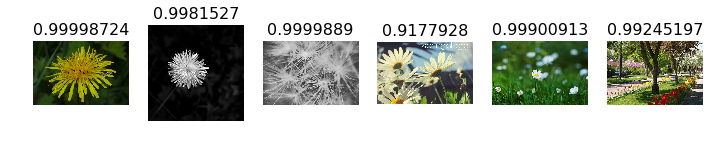

In [190]:
# here are some examples of correctly labelled images
vgg_correct = 0;
for i in range(len(vgg_model_labels)):
    if(vgg_model_labels[i]==expected_labels[i]):
        vgg_correct += 1
print ("There are a total of " + str(vgg_correct) + " correct labels")
index = np.random.permutation(vgg_correct)[:n_view]
plots_idx(index, np.array(vgg_model_label_confidence)[index])

There are a total of 141 incorrect labels
predicted: tulip
actual:  sunflower
predicted: daisy
actual:  dandelion
predicted: daisy
actual:  dandelion
predicted: dandelion
actual:  daisy
predicted: sunflower
actual:  dandelion
predicted: tulip
actual:  daisy


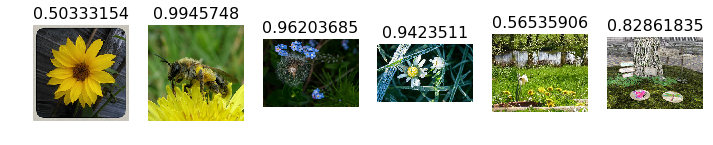

In [193]:
# here are some examples of incorrectly labeled images
vgg_incorrect = [];
for i in range(len(vgg_model_labels)):
    if(vgg_model_labels[i]!=expected_labels[i]):
        vgg_incorrect.append(i)
print ("There are a total of " + str(len(vgg_incorrect)) + " incorrect labels")
index = np.random.permutation(vgg_incorrect)[:n_view]
plots_idx(index, np.array(vgg_model_label_confidence)[index])
for i in index:
    filename = vgg_test_batches.filenames[i]
    filename = filename[filename.index('\\')+1:filename.index('.')]
    if(vgg_model_labels[i] == 0):
        predicted = "daisy"
    if(vgg_model_labels[i] == 1):
        predicted = "dandelion"
    if(vgg_model_labels[i] == 2):
        predicted = "rose"
    if(vgg_model_labels[i] == 3):
        predicted = "sunflower"
    if(vgg_model_labels[i] == 4):
        predicted = "tulip"
    print("predicted: "+ predicted)
    print("actual: ", filename)

There are a total of 692 correct labels


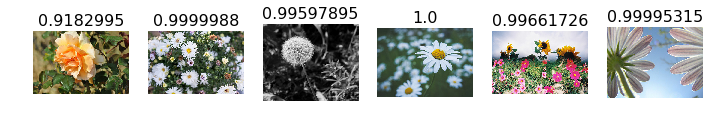

In [289]:
# here are some examples of correctly labelled images
resnet_correct = 0;
for i in range(len(resnet_model_labels)):
    if(resnet_model_labels[i]==expected_labels[i]):
        resnet_correct += 1
print ("There are a total of " + str(resnet_correct) + " correct labels")
index = np.random.permutation(resnet_correct)[:n_view]
plots_idx(index, np.array(resnet_model_label_confidence)[index])

There are a total of 172 incorrect labels
predicted: dandelion
predicted:  3
actual:  tulip
predicted: tulip
predicted:  4
actual:  rose
predicted: tulip
predicted:  4
actual:  dandelion
predicted: dandelion
predicted:  0
actual:  dandelion
predicted: sunflower
predicted:  0
actual:  sunflower
predicted: dandelion
predicted:  0
actual:  dandelion


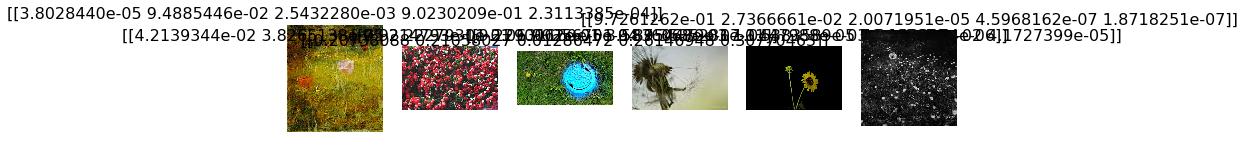

In [195]:
# here are some examples of incorrectly labeled images
resnet_incorrect = [];
for i in range(len(resnet_model_labels)):
    if(resnet_model_labels[i]!=expected_labels[i]):
        resnet_incorrect.append(i)
print ("There are a total of " + str(len(resnet_incorrect)) + " incorrect labels")
index = np.random.permutation(resnet_incorrect)[:n_view]
plots_idx(index, np.array(resnet_model_label_confidence)[index])
for i in index:
    filename = resnet_test_batches.filenames[i]
    filename = filename[filename.index('\\')+1:filename.index('.')]
    if(vgg_model_labels[i] == 0):
        predicted = "daisy"
    if(vgg_model_labels[i] == 1):
        predicted = "dandelion"
    if(vgg_model_labels[i] == 2):
        predicted = "rose"
    if(vgg_model_labels[i] == 3):
        predicted = "sunflower"
    if(vgg_model_labels[i] == 4):
        predicted = "tulip"
    print("predicted: "+ predicted)
    print("predicted: ", resnet_model_labels[i])
    print("actual: ", filename)

## Overview of results

In [176]:
# vgg generalization error
print("Finetuned VGG16's generalization error is:" + str(vgg_correct/len(expected_labels)*100) + "%")
print("Finetuned Resnet50's generalization error is:" + str(resnet_correct/len(expected_labels)*100) + "%")

Finetuned VGG16's generalization error is:17.01388888888889%
Finetuned Resnet50's generalization error is:25.578703703703702%
